In [1]:
from optimization import *
import optimization
import sys
import importlib
import rotation
importlib.reload(optimization)
sys.path.append("../python")
import parseCouplings
sys.path.append("../Netket")

In [2]:
# Todo: replace this function with actual file reading
def readHamiltonian_params(file, idx, N):
    Jijalphabeta = np.random.rand(3, 3, N, N)
    h = np.random.rand(3, N)

    # Delete 90% of the elements randomly in Jijalphabeta
    mask_J = np.random.rand(3, 3, N, N) < 0.1
    Jijalphabeta = Jijalphabeta * mask_J

    # Delete 90% of the elements randomly in h
    mask_h = np.random.rand(3, N) < 0.1
    h = h * mask_h

    return Jijalphabeta, h


def generate_tfim_params(N, J=1.0, h=1.0):
    """
    Generates Jij and h arrays for the transverse field Ising model (TFIM):
    H = -J sum_{<i,j>} sigma^z_i sigma^z_j - h sum_i sigma^x_i

    Args:
        N (int): Number of spins (1D chain with periodic boundary).
        J (float): Coupling strength.
        h (float): Transverse field strength.

    Returns:
        Jij (np.ndarray): shape (3, 3, N, N), only Jij[2,2,i,j] nonzero for nearest neighbors.
        h (np.ndarray): shape (3, N), only h[0,i] nonzero (x direction).
    """
    Jij = np.zeros((3, 3, N, N))
    for i in range(N):
        j = (i + 1) % N  # periodic boundary
        Jij[2, 2, i, j] = -J
        Jij[2, 2, j, i] = -J  # symmetric

    h_arr = np.zeros((3, N))
    h_arr[0, :] = -h  # transverse field in x direction

    return Jij, h_arr

def TFI2D(g, J=1.0, h=1.0):
    hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    H = -J*sum(nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, j) for( i, j) in g.edges()) 
    H += -h*sum(nk.operator.spin.sigmax(hi,i) for i in g.nodes())

    return H
g = nk.graph.Hypercube(length=4, n_dim=2, pbc=True)

def construct_hamiltonian_bonds_heisenberg(Jijalphabeta, h, bonds):
    # Jijalphabeta = np.array([np.eye(3)*np.max(Jijalphabeta[bond,:,:]) for bond in range(len(bonds))])
    Jijalphabeta = np.array([np.eye(3) for bond in range(len(bonds))])
    return construct_hamiltonian_bonds(Jijalphabeta, h, bonds)


In [3]:
Jij,h,bonds = parseCouplings.parseCouplings("../python/couplings69.csv")

In [18]:
# Jij, h = readHamiltonian_params("hamiltonian_params.txt", 0, 5)
import os
os.chdir("../python")
Jij,h,bonds = parseCouplings.parseCouplings()
# H_ran = construct_hamiltonian_bonds_heisenberg(Jij[10], 0*h[10],  bonds[10])
H_ran = construct_hamiltonian_bonds_rotated(Jij[18], h[18],  bonds[18], 0.1,0.2,0.3)
epsilon = 0.8
# H2 = TFI2D(g, 1, 0.5)
H = H_ran
# H = epsilon*H_ran + H2
exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)
print("Exact ground state energy:", exact_ground_energy)
import analysis
print(analysis.uniform_state_overlap(exact_ground_state))


Exact ground state energy: [-53.25958489]
1.691505902019699e-30


In [19]:
importlib.reload(optimization)

<module 'optimization' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/python/../Netket/optimization.py'>

In [28]:
Jij_hash = hash(Jij.tobytes())
h_hash = hash(h.tobytes())

params = generate_params(
    alpha=4,
    seed=1234,
    learning_rate=1e-3,
    n_iter=300,
    show_progress=True,
    out="data/rbm_optimization_test_def",
    # symmetries = g.automorphisms(),
    H_hash = hash(H),
    diag_shift=1e-3,
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

out = optimize_rbm(H, params)


RBM


  0%|          | 0/300 [00:00<?, ?it/s]

In [32]:
params2 = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=5e-3,
    n_iter=200,
    show_progress=True,
    out="data/rbm_optimization_test_modphase",
    model_type='RBMModPhase',
    param_dtype=np.float64,
    # symmetries = g.automorphisms(),
    epsilon = epsilon,
    diag_shift=8e-3,
    # Jij_hash=Jij_hash,
    # h_hash=h_hash,
)

out2 = optimize_rbm(H, params2)

RBMModPhase
Using RBModPhase


  0%|          | 0/200 [00:00<?, ?it/s]

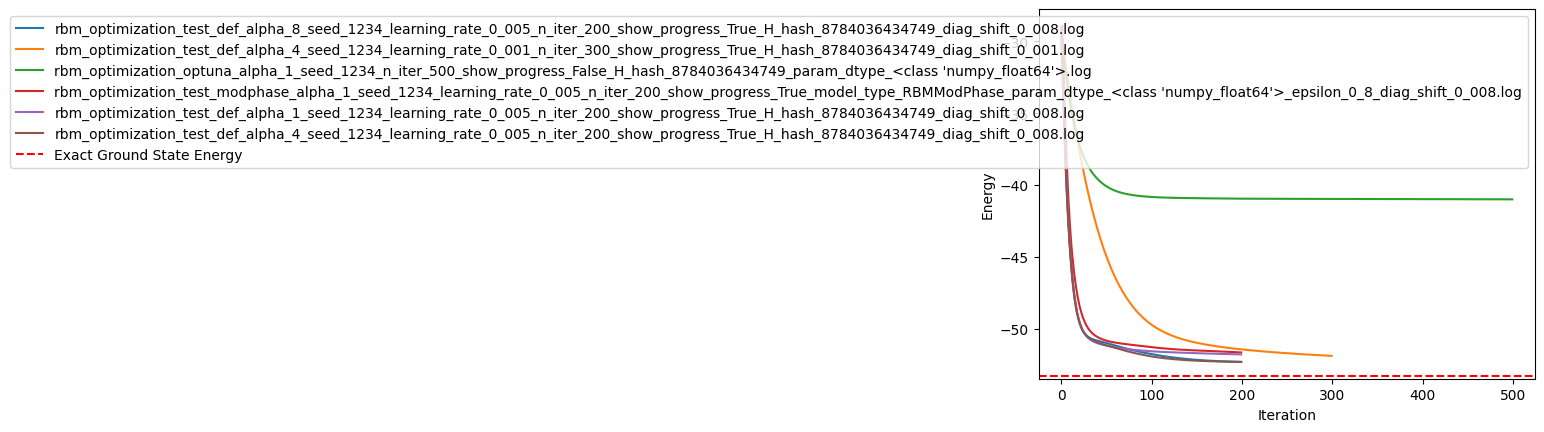

In [31]:
import json
import os
import matplotlib.pyplot as plt
log_files = [os.path.join("data", f) for f in os.listdir("data") if f.endswith(".log")]

fig, ax = plt.subplots()

# Extract the common prefix from all log file names

for log_file in log_files:
    with open(log_file) as f:
        data_rbm = json.load(f)
    iters = data_rbm["Energy"]["iters"]
    energy = data_rbm["Energy"]["Mean"]["real"]
    # Use the substring that differs from the common prefix as the label
    label = os.path.basename(log_file)
    ax.plot(iters, energy, label=label)

ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
plt.axhline(y=exact_ground_energy, color='r', linestyle='--', label='Exact Ground State Energy')
ax.legend()
plt.show()


In [30]:
import optuna

def optimize_learning_rate_and_diag_shift(H, params_template, n_trials=20):
    """
    Optimize the learning rate and diag_shift using Optuna.

    Args:
        H: Hamiltonian to optimize.
        params_template (dict): Template for parameters. Other parameters will remain fixed.
        n_trials (int): Number of trials for optimization.

    Returns:
        optuna.study.Study: The study object containing the optimization results.
    """
    def objective(trial):
        # Suggest values for learning_rate and diag_shift
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
        diag_shift = trial.suggest_float('diag_shift', 1e-5, 1e-1, log=True)
        
        # Update the parameters with the suggested values
        params = params_template.copy()
        params['learning_rate'] = learning_rate
        params['diag_shift'] = diag_shift
        
        # Optimize the RBM
        out = optimize_rbm(H, params)
        
        # Calculate the energy expectation value
        energy = out.expect(H).real().mean
        return energy

    # Create and run the study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    return study

params_template = generate_params(
    alpha=1,
    seed=1234,
    n_iter=500,
    show_progress=False,
    out="data/rbm_optimization_optuna",
    H_hash = hash(H),
    param_dtype=np.float64,
)
study = optimize_learning_rate_and_diag_shift(H, params_template, n_trials=20)

[I 2026-01-19 15:34:12,240] A new study created in memory with name: no-name-d339283d-317c-4b4f-a450-3772f418e3b8
/tmp/ipykernel_52533/3444794193.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_52533/3444794193.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  diag_shift = trial.suggest_loguniform('diag_shift', 1e-5, 1e-1)


RBM


[I 2026-01-19 15:34:23,423] Trial 0 finished with value: -5.218751253348608 and parameters: {'learning_rate': 0.042697573921723186, 'diag_shift': 0.000994545508358465}. Best is trial 0 with value: -5.218751253348608.
/tmp/ipykernel_52533/3444794193.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_52533/3444794193.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  diag_shift = trial.suggest_loguniform('diag_shift', 1e-5, 1e-1)


RBM


[I 2026-01-19 15:36:36,390] Trial 1 finished with value: -40.91473246925574 and parameters: {'learning_rate': 0.0008292571966581506, 'diag_shift': 0.0011685986179459202}. Best is trial 1 with value: -40.91473246925574.


RBM


[I 2026-01-19 15:38:01,627] Trial 2 finished with value: -41.24698598218382 and parameters: {'learning_rate': 0.011946033164955835, 'diag_shift': 0.00538700414697679}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:38:15,851] Trial 3 finished with value: -34.666618629901 and parameters: {'learning_rate': 6.581379960791928e-05, 'diag_shift': 0.09477604955808484}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:38:30,648] Trial 4 finished with value: -33.80596622398767 and parameters: {'learning_rate': 4.78424096581312e-05, 'diag_shift': 0.05945409210330983}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:39:54,731] Trial 5 finished with value: -37.11407723295352 and parameters: {'learning_rate': 7.703477194531328e-05, 'diag_shift': 7.659990107688923e-05}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:44:32,727] Trial 6 finished with value: -40.91868598150086 and parameters: {'learning_rate': 0.0005163462655669407, 'diag_shift': 0.00011519483640008524}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:45:20,984] Trial 7 finished with value: -33.55312387388231 and parameters: {'learning_rate': 3.1549094799612515e-05, 'diag_shift': 0.0003660233614523381}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:45:53,524] Trial 8 finished with value: -39.90553990095784 and parameters: {'learning_rate': 0.0002095277797354042, 'diag_shift': 0.016442425609106553}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:48:33,079] Trial 9 finished with value: -40.913808007168655 and parameters: {'learning_rate': 0.0005015402477587773, 'diag_shift': 0.00046542280076125294}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:48:49,815] Trial 10 finished with value: -16.950405192706608 and parameters: {'learning_rate': 0.012414496794699458, 'diag_shift': 1.216117401340188e-05}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:50:13,973] Trial 11 finished with value: -40.98248226534961 and parameters: {'learning_rate': 0.00468886526250238, 'diag_shift': 0.005872716717394502}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:51:46,312] Trial 12 finished with value: -40.95388555065662 and parameters: {'learning_rate': 0.006495748703465555, 'diag_shift': 0.00497988940462445}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:53:12,366] Trial 13 finished with value: -40.942852557294465 and parameters: {'learning_rate': 0.0058944693191904365, 'diag_shift': 0.005854278657860457}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:53:24,381] Trial 14 finished with value: -5.713525465593622 and parameters: {'learning_rate': 0.0732942750128623, 'diag_shift': 0.00799461420081235}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:54:13,863] Trial 15 finished with value: -40.870016867744276 and parameters: {'learning_rate': 0.003346962725993607, 'diag_shift': 0.01940777826541959}. Best is trial 2 with value: -41.24698598218382.


RBM


[I 2026-01-19 15:56:13,258] Trial 16 finished with value: -41.30331179236139 and parameters: {'learning_rate': 0.01971992336138985, 'diag_shift': 0.00237535735575901}. Best is trial 16 with value: -41.30331179236139.


RBM


[I 2026-01-19 15:58:25,272] Trial 17 finished with value: -41.29855422768983 and parameters: {'learning_rate': 0.02144540204530906, 'diag_shift': 0.001974353691942362}. Best is trial 16 with value: -41.30331179236139.


RBM


[I 2026-01-19 16:00:58,081] Trial 18 finished with value: -41.31417478222124 and parameters: {'learning_rate': 0.025508842172862273, 'diag_shift': 0.0014156352399925245}. Best is trial 18 with value: -41.31417478222124.


RBM


[I 2026-01-19 16:05:37,970] Trial 19 finished with value: -40.988632054210115 and parameters: {'learning_rate': 0.0018930581669227328, 'diag_shift': 0.0002162912036906975}. Best is trial 18 with value: -41.31417478222124.


In [ ]:
import analysis
analysis.read_h5_attributes(params2["out"] + ".h5")

{'alpha': np.int64(1),
 'epsilon': np.float64(0.1),
 'learning_rate': np.float64(0.003),
 'n_iter': np.int64(400),
 'out': 'data/rbm_optimization_test_2_alpha_1_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_symmetric_False_epsilon_0_1',
 'seed': np.int64(1234),
 'show_progress': np.True_,
 'symmetric': np.False_}

In [ ]:
write_output(H, out2, params2)

Could not read log file data/rbm_optimization_test_2_alpha_48_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_epsilon_0_8_diag_shift_0_01.log: [Errno 2] No such file or directory: 'data/rbm_optimization_test_2_alpha_48_seed_1234_learning_rate_0_003_n_iter_400_show_progress_True_epsilon_0_8_diag_shift_0_01.log'
Flipping the sign of the ground state wavefunction to ensure positive overlap.


In [40]:
params = generate_params(
    alpha=1,
    seed=1234,
    learning_rate=8e-3,
    n_iter=300,
    show_progress=True,
    rot_alpha= 0,
    rot_beta=0.5*np.pi,
    rot_gamma=0.6241423,
    out=f"../data/data_rotated/rbm_optimization",
)
params["out"]

'../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_300_show_progress_True_rot_alpha_0_rot_beta_1_5707963267948966_rot_gamma_0_6241423'

In [43]:
Jij,h,bonds = parseCouplings.parseCouplings("../python/couplings69.csv")
angle_range = np.linspace(0, 0.5*np.pi, 2)

for alpha in angle_range:
    for beta in angle_range:
        for gamma in angle_range:
            H = construct_hamiltonian_bonds_rotated(Jij[50], h[50],  bonds[50], alpha, beta, gamma)
            exact_ground_energy,exact_ground_state = nk.exact.lanczos_ed(H, k = 1, compute_eigenvectors = True)

            print(f"Angles: ({alpha:.2f}, {beta:.2f}, {gamma:.2f}), Hamiltonian: Exact ground state energy: {exact_ground_energy[0]}")

            params = generate_params(
                alpha=1,
                seed=1234,
                learning_rate=8e-3,
                n_iter=400,
                show_progress=True,
                rot_alpha=alpha,
                rot_beta=beta,
                rot_gamma=gamma,
                out=f"../data/data_rotated/rbm_optimization",
            )
            out = optimize_rbm(H, params)
            
            write_output(H, out, params)

Angles: (0.00, 0.00, 0.00), Hamiltonian: Exact ground state energy: -54.26621412990654


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 0.00, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 1.57, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (0.00, 1.57, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906594


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 0.00, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906764


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 0.00, 1.57), Hamiltonian: Exact ground state energy: -54.26621412990656


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 1.57, 0.00), Hamiltonian: Exact ground state energy: -54.266214129906736


  0%|          | 0/400 [00:00<?, ?it/s]

Angles: (1.57, 1.57, 1.57), Hamiltonian: Exact ground state energy: -54.266214129906835


  0%|          | 0/400 [00:00<?, ?it/s]

In [5]:
import os

# h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]
h5_files = [os.path.join("../data/data_rotated", f) for f in os.listdir('../data/data_rotated') if f.endswith('.h5')]
print(h5_files)

['../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_3693876085377084_rot_beta_0_764288275501484_rot_gamma_1_531411503936541.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_44459293368815256_rot_beta_0_008973149430378965_rot_gamma_0_4593948646110098.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_36456339480663824_rot_beta_1_3272476633202974_rot_gamma_0_976046924083371.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_1_025806591604705_rot_beta_0_6636879804448029_rot_gamma_0_40389680946782824.h5', '../data/data_rotated/rbm_optimization_alpha_1_seed_1234_learning_rate_0_008_n_iter_400_show_progress_False_rot_alpha_0_8636729976004734_rot_beta_0_894598848776103_rot_gamma_0_1542775870366362.h5', '../

In [6]:
from analysis import *
load_outputs_to_dataframe(h5_files)

,psi,psi_0,Delta_E,infidelity
0,"[(-0.0009071705+0.00031600223j), (0.0003175422...",[(-0.0011822779292414843+0.0006514321570310087...,0.103743,0.990176
1,"[(-1.0200166e-05+9.107927e-06j), (8.151106e-06...",[(-1.808286313931901e-07+3.2005616770418713e-0...,0.123186,0.999948
2,"[(0.001995487-0.023808798j), (-0.005822409+0.0...","[(0.007111324009398755-0.023676767848941994j),...",0.000733,0.002392
3,"[(0.0041645826-0.006317043j), (-0.00053992827+...",[(-0.007333034090437174-2.849224019744056e-05j...,0.000531,0.001442
4,"[(0.007687317+0.0068763364j), (-0.007626226+0....","[(0.010362418637859106+0.003490020874530769j),...",0.001576,0.004966
5,"[(-0.020315237+0.02570005j), (0.013498547-0.01...","[(0.022037945842076318-0.029903528534419344j),...",0.067546,0.697001
6,"[(-2.9715607e-06-1.18197946e-07j), (2.1757134e...",[(-0.00047126691192422637+0.000426507344858401...,0.122952,0.999761
7,"[(-5.344648e-07-2.282598e-05j), (1.6885562e-05...",[(-1.2387411686823587e-06+1.0086708220736559e-...,0.119888,0.998356
8,"[(0.007199597+0.0066867205j), (-0.00829119+0.0...",[(0.008502770886371745+0.0039914278156320095j)...,0.000494,0.001289
9,"[(0.011822619+0.0041554035j), (-0.00958271-0.0...","[(0.0018785822392949068+0.01273557525003682j),...",0.003552,0.025589


In [22]:
import optuna
def objective(trial):
    # Suggest values for alpha, beta, gamma in [0, 0.5*np.pi]
    alpha = trial.suggest_float('alpha', 0, 0.5*np.pi)
    beta = trial.suggest_float('beta', 0, 0.5*np.pi)
    gamma = trial.suggest_float('gamma', 0, 0.5*np.pi)
    
    # Construct Hamiltonian with suggested angles
    H = construct_hamiltonian_bonds_rotated(Jij[50], h[50], bonds[50], alpha, beta, gamma)
    
    params = generate_params(
        alpha=1,
        seed=1234,
        learning_rate=8e-3,
        n_iter=400,
        show_progress=False,
        rot_alpha=alpha,
        rot_beta=beta,
        rot_gamma=gamma,
        out=f"../data/data_rotated/rbm_optimization",
    )
    out = optimize_rbm(H, params)
    write_output(H, out, params)
    en = out.expect(H).real().mean
    return en

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best angles found:")
print("alpha =", study.best_params['alpha'])
print("beta =", study.best_params['beta'])
print("gamma =", study.best_params['gamma'])
print("Minimum ground state energy =", study.best_value)

[I 2025-09-29 18:58:44,397] A new study created in memory with name: no-name-09990567-cc5e-402a-99bb-d46990878aac
[I 2025-09-29 18:59:41,094] Trial 0 finished with value: -47.61823726144692 and parameters: {'alpha': 0.992825121449861, 'beta': 0.28184134120550663, 'gamma': 1.1704005709525558}. Best is trial 0 with value: -47.61823726144692.
[I 2025-09-29 19:00:54,298] Trial 1 finished with value: -47.58141012177944 and parameters: {'alpha': 0.44459293368815256, 'beta': 0.008973149430378965, 'gamma': 0.4593948646110098}. Best is trial 0 with value: -47.61823726144692.
[I 2025-09-29 19:01:58,033] Trial 2 finished with value: -47.766371041298314 and parameters: {'alpha': 0.1148616042331309, 'beta': 0.216217833955141, 'gamma': 1.4334885673588642}. Best is trial 2 with value: -47.766371041298314.
[I 2025-09-29 19:03:12,716] Trial 3 finished with value: -54.23380740311619 and parameters: {'alpha': 0.15770960222919114, 'beta': 1.4469284030393488, 'gamma': 0.7115125625756978}. Best is trial 3 w

Best angles found:
alpha = 0.18610694312202125
beta = 1.4130236875883821
gamma = 1.4413482562269746
Minimum ground state energy = -54.24264712903329


In [9]:
# os.chdir("Netket")
import importlib
import analysis
importlib.reload(analysis)

<module 'analysis' from '/net/storage/niggeni/Documents/Projects/DataMiningRBMs/python/../Netket/analysis.py'>

In [29]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}
df = load_outputs_to_dataframe(h5_files)
df = attach_hypotheses_fields(df, hypotheses)
df["rot_alpha"] = np.array([analysis.read_h5_attributes(f)["rot_alpha"] for f in h5_files])
df["rot_beta"] = np.array([analysis.read_h5_attributes(f)["rot_beta"] for f in h5_files])
df["rot_gamma"] = np.array([analysis.read_h5_attributes(f)["rot_gamma"] for f in h5_files])

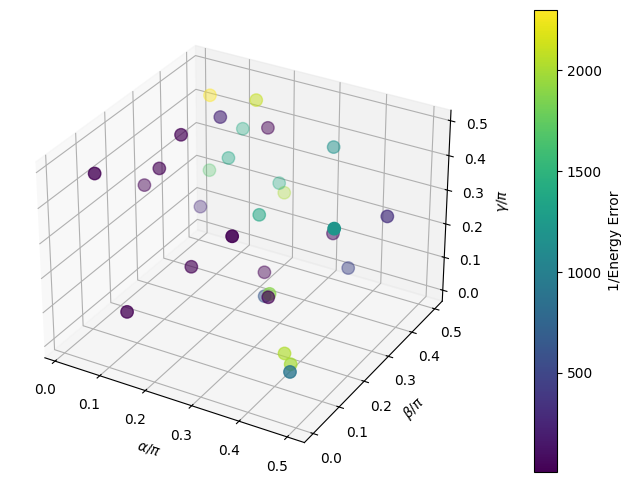

In [11]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Extract rotation angles and energy error
energy_error = 1/df["Delta_E"]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df["rot_alpha"]/np.pi, df["rot_beta"]/np.pi, df["rot_gamma"]/np.pi, c=energy_error, cmap='viridis', s=80)
ax.set_xlabel(r"$\alpha/\pi$")
ax.set_ylabel(r"$\beta/\pi$")
ax.set_zlabel(r"$\gamma/\pi$")
plt.colorbar(sc, label="1/Energy Error", pad=0.1)
plt.show()

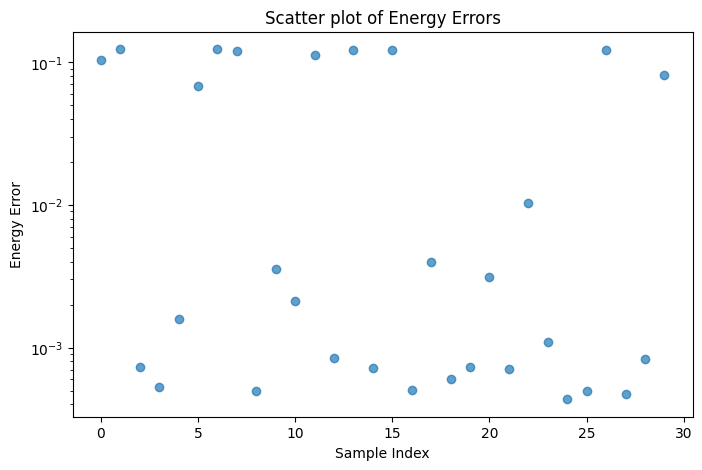

In [24]:
import matplotlib.pyplot as plt

# Assuming df["Delta_E"] contains arrays, extract the first element for each entry
energies = df["Delta_E"]

plt.figure(figsize=(8, 5))
plt.scatter(range(len(energies)), energies, alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Energy Error")
plt.yscale("log")
plt.title("Scatter plot of Energy Errors")
plt.show()

In [32]:
Jij[50][0,:,:]

array([[-0.41859285,  0.63976083, -1.5100352 ],
       [ 0.83865364,  0.86525379,  0.50709675],
       [-0.44708352,  0.8977601 ,  0.16044521]])

Jij[50] before rotation:
 [[-0.31733708  0.61595921  0.54596863]
 [-0.62777364 -0.18191422  0.08496754]
 [-0.07472594  0.23461322 -2.28606964]]
h[50] before rotation:
 [-0.17039252  0.10899523  0.70310945]

Optimal rotation angles: alpha=0.18610694312202125, beta=1.4130236875883821, gamma=1.4413482562269746
Jij[50] after optimal rotation:
 [[-0.47323043 -0.56003959 -0.67266319]
 [-0.88182107 -1.87784598  0.00253944]
 [ 0.28007585 -0.96868247 -0.43424453]]
h[50] after optimal rotation:
 [0.10999631 0.66691242 0.28000911]


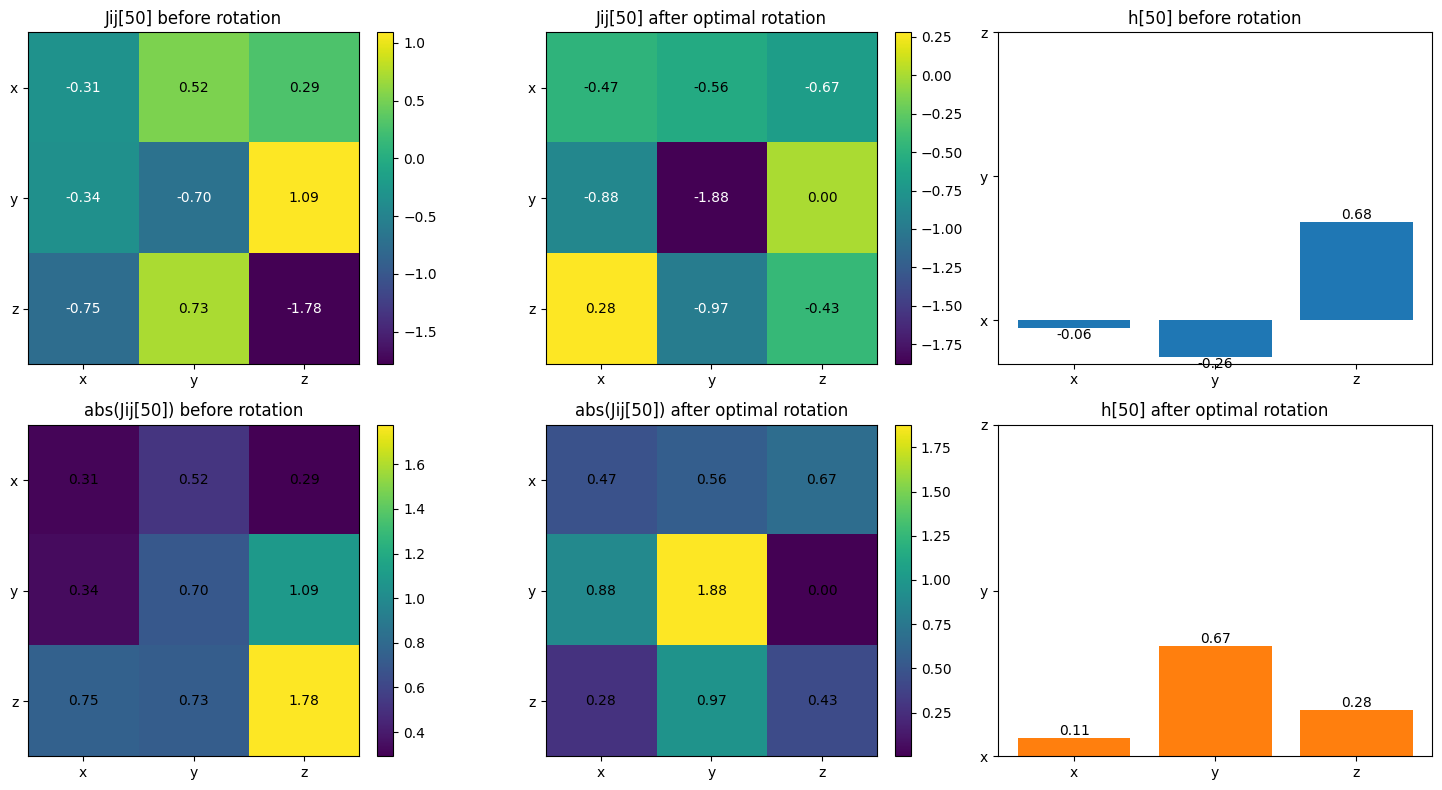

In [38]:
print("IPR of the best rotation (min Delta_E):", df["IPR"][min_idx])
print("delta E of the best rotation (min Delta_E):", df["Delta_E"][min_idx])

print("IPR of the worst rotation (max Delta_E):", df["IPR"][max_idx])
print("delta E of the worst rotation (max Delta_E):", df["Delta_E"][max_idx])

IPR of the best rotation (min Delta_E): 3.655221481174877e-05
delta E of the best rotation (min Delta_E): 0.00043463943277260205
IPR of the worst rotation (max Delta_E): 0.007731874773239227
delta E of the worst rotation (max Delta_E): 0.12318612179702386


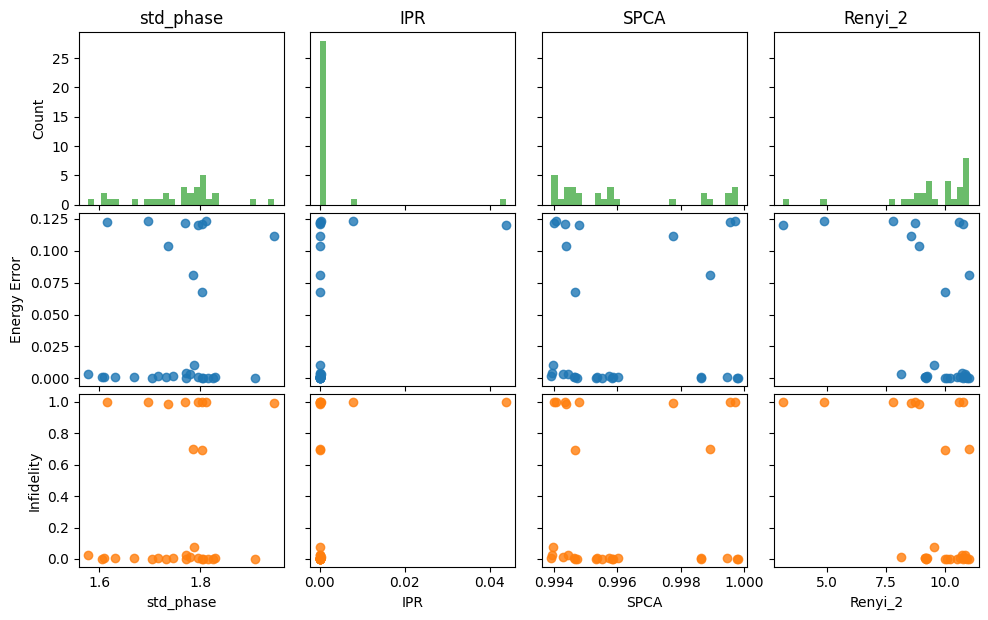

In [30]:
import matplotlib.pyplot as plt
N = len(hypotheses)
fig, axes = plt.subplots(3, N, figsize=(0.6*4*N, 0.6*10), sharey='row', sharex='col')

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram of hypothesis values
    axes[0, idx].hist(df[name], bins=30, color="C2", alpha=0.7)
    axes[0, idx].set_title(f"{name}")
    if idx == 0:
        axes[0, 0].set_ylabel("Count")

    # Second row: Energy error vs hypothesis
    axes[1, idx].scatter(df[name], df["Delta_E"], color="C0", alpha=0.8)
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")

    # Third row: Infidelity vs hypothesis
    infid = df.apply(lambda row: infidelity(row["psi"], row["psi_0"]), axis=1)
    axes[2, idx].scatter(df[name], infid, color="C1", alpha=0.8)
    axes[2, idx].set_xlabel(name)
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")

plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()


In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df["Delta_E"], infid, alpha=0.7)
plt.xlabel("Energy Error")
plt.ylabel("Infidelity")
plt.show()